In [226]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
from collections import Counter
import pickle
import numpy_groupies as npg

In [190]:
def get_images(name, size):
    images = np.empty((size, 784), dtype=np.int16)
    numbers = np.empty(size, dtype=np.int32)

    with open(name, 'rt') as file:
        for i in range(size):
            row = file.readline().split(',')

            numbers[i] = row[0]
            images[i] = row[1:]


    return numbers, images

def show_image(image):
    plt.imshow(image.reshape((28,28)), cmap='gray')
    plt.show()

def k_nearest_neighbour_old(image, numbers, images, k):
    sorted_indices = np.argsort(np.linalg.norm(images-image, axis=-1))
    return Counter(numbers[i] for i in sorted_indices[:k]).most_common(1)[0][0]

# Find k nearest neighbours
#   Take first k values and sort
#   Go over the rest and insert if its smaller than the maximum value
# Generate all smaller results

# def k_nearest_neighbours(train_images, test_image, k, dist_func):
#     '''Returns nearest k indices in order of closest'''
#     return np.argpartition(dist_func(train_images, test_image), range(1,k+1), axis=-1)[:k]

# neighbour_func = lambda x: k_nearest_neighbours(images_train_small, x, k_range, euclid_dist)
# arg_max_func = lambda k: np.argmax(npg.aggregate(numbers_train_small[list(map(neighbour_func, images_test_small[:2]))][:k], 1))
# result = list(map(arg_max_func, range(1,k_range+1)))

def euclid_dist(train_images, test_image):
    return np.linalg.norm(train_images-test_image, axis=-1)



In [126]:
# MNIST_train 60000 images
# MNIST_test 10000 images
# MNIST_train_small 3000 images
# MNIST_test_small 1000 images

# 11 seconds for 60000 images
# images = get_images('data/MNIST_train.csv', 60000)
numbers_train_small, images_train_small = get_images('data/MNIST_train_small.csv', 3000)
numbers_test_small, images_test_small = get_images('data/MNIST_test_small.csv', 1000)

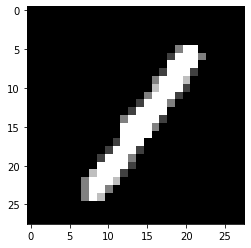

In [127]:
show_image(images_test_small[2])

In [185]:
def k_nearest_neighbours(train_images, train_numbers, test_image, k, dist_func):
    norm_list = dist_func(train_images, test_image)
    nearest_idx = np.empty(k, dtype=np.int32)
    common_nr = np.empty(k, dtype=np.int8)
    for i in range(k):
        min_idx = np.argmin(norm_list)
        norm_list[min_idx] = np.inf
        nearest_idx[i] = min_idx

        common_nr[i] = Counter(train_numbers[nearest_idx[:i+1]]).most_common(1)[0][0]

    return common_nr

In [207]:
k = 20
neighbour_func = lambda img: k_nearest_neighbours(images_train_small, numbers_train_small, img, k, euclid_dist)

In [236]:
# Train data compared with test data
test_common_nrs = np.array(list(map(neighbour_func, images_test_small))).transpose()

In [238]:
not_eq = lambda x,y: x != y

# Emprical risk on the test set
test_small_risk = np.sum(not_eq(test_common_nrs, numbers_test_small), axis=1)/numbers_test_small.shape[0]
print(test_small_risk)

[0.085 0.085 0.077 0.076 0.072 0.076 0.08  0.081 0.083 0.09  0.095 0.097
 0.098 0.103 0.103 0.105 0.104 0.111 0.112 0.113]


In [218]:
# Train data compared with train data
train_common_nrs = np.array(list(map(neighbour_func, images_train_small))).transpose()

In [237]:
# Emprical risk on the train set
train_small_risk = np.sum(not_eq(train_common_nrs, numbers_train_small), axis=1)/numbers_train_small.shape[0]
print(train_small_risk)

[0.         0.         0.02733333 0.027      0.04066667 0.04266667
 0.05133333 0.05333333 0.06233333 0.06266667 0.07066667 0.07033333
 0.07533333 0.07333333 0.08033333 0.08066667 0.08433333 0.083
 0.08466667 0.08566667]


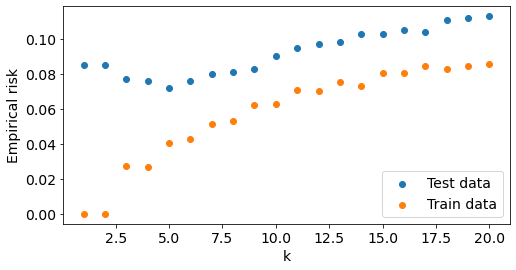

In [234]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(range(1,k+1), test_small_risk, label='Test data')
ax.scatter(range(1,k+1), train_small_risk, label='Train data')
ax.legend(loc=4)
ax.set_xlabel("k")
ax.set_ylabel("Empirical risk")

# plt.savefig("ex_a_risk.pdf")
plt.show()

# Best k for this model is five!

In [245]:
" & ".join(list(str(i) for i in range(20)))

'0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 & 10 & 11 & 12 & 13 & 14 & 15 & 16 & 17 & 18 & 19'

### Function speed tests

In [181]:
norm_list = np.linalg.norm(images_train_small-images_test_small[0], axis=-1)

In [97]:
%%timeit
for i in range(20):
    min_idx = np.argmin(norm_list)
    norm_list[min_idx] = np.inf
    nearest_arr[i] = min_idx

31.3 ms ± 4.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [73]:
%timeit np.argsort(norm_list)[:20]
%timeit np.argpartition(norm_list, range(1,21), axis=-1)[:20]

148 µs ± 944 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
100 µs ± 639 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
3.21 µs ± 10.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [15]:
f = lambda x: x ** 2
uf = np.frompyfunc(f, 1, 1)
g = lambda x, y: x + y
x = np.arange(1000)
y = np.arange(1000)
vf = np.vectorize(f)

# f(x) 1.48 mirco s
# g(x,y) 1.33 micro s
# uf(x) 284 micro s
# vf(x) 313 micro s
# np.fromiter((f(i) for i in x), x.dtype, count=len(x)) 402 micro s
# np.array(list(map(f, x))) 442 micro s
# np.array([f(i) for i in x], dtype=x.dtype) 487 micro s
# normal for loop 511 micro s
# arr = np.empty(x.shape)
# for i in range(x.size):
#   arr[i] = f(x[i])

In [156]:
%timeit np.argmax(npg.aggregate(numbers_train_small[nearest_arr], 1))

47 µs ± 2.75 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [157]:
%timeit Counter(numbers_train_small[nearest_arr]).most_common(1)[0][0]

7.74 µs ± 186 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
